<h1 align="center" style="margin-top:10px">Lesson 6</h1>

### Text features

Often you will have the opportunity to improve a machine learning model using text data. This can be a description of the company, a review of the user or his requests. Of course, we can't feed the text into the model, so it has to be translated into numbers in some way. In this lesson, we'll look at ways to create features from text data. Let's do this using data from Twitter as an example.

In [3]:
import warnings
warnings.filterwarnings("ignore")

import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
#sns.set_context('notebook') 
sns.set_style('ticks')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
data=pd.read_pickle('processed_tweets.pickle')
data.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,tokens,positive
14630,569588473050611712,positive,1.0,NaN,NaN,American,NaN,Laurelinesblog,NaN,0,@AmericanAir Thanks! He is.,NaN,2015-02-22 12:04:09 -0800,"Chapel Hill, NC",NaN,"[@americanair, thank]",1
14631,569588464896876545,negative,1.0,Bad Flight,1.0000,American,NaN,MDDavis7,NaN,0,@AmericanAir thx for nothing on getting us out...,NaN,2015-02-22 12:04:07 -0800,US,Eastern Time (US & Canada),"[@americanair, thx, noth, get, us, countri, ba...",0
14633,569587705937600512,negative,1.0,Cancelled Flight,1.0000,American,NaN,RussellsWriting,NaN,0,@AmericanAir my flight was Cancelled Flightled...,NaN,2015-02-22 12:01:06 -0800,Los Angeles,Arizona,"[@americanair, flight, cancel, flightl, leav, ...",0
14636,569587371693355008,negative,1.0,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN,"[@americanair, leav, 20, minut, late, flight, ...",0
14638,569587188687634433,negative,1.0,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada),"[@americanair, money, chang, flight, don't, an...",0


Examples of negative and positive tweets

In [ ]:
data.loc[4126, 'text']

'@united stuck here in IAH waiting on flight 253 to Honolulu for 7 hours due to maintenance issues. Could we have gotten a new plane!?!? Fail'

In [ ]:
data.loc[8644, 'text']

'@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!'

Let's try to solve the problem of ***sentiment analysis***.

As usual, we split the data into training (70%) and test (30%) sets before proceeding. 

In [ ]:
# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=1)

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

## Exploratory Data Analysis


We start with some exploratory data analysis for the training data. We find that, overall, 83.1% of the tweets are negative and 16.9% are positive.

In [ ]:
train['airline_sentiment'].value_counts()

negative    5176
positive    1051
Name: airline_sentiment, dtype: int64

In [ ]:
train['airline_sentiment'].value_counts(normalize=True).round(3)

negative    0.831
positive    0.169
Name: airline_sentiment, dtype: float64

We can use cross tabulation to break down the numbers by airline.

In [ ]:
table=pd.crosstab(train['airline_sentiment'], train['airline'])
table

airline,American,Delta,Southwest,US Airways,United,Virgin America
airline_sentiment,,,,,,
negative,1156,467,632,1334,1491,96
positive,148,241,268,111,210,73


It seems to be easier for small companies to control the quality of services. American, US Airways, and United in particular had a high proportion of complaints that month:

In [ ]:
table = (table/table.sum()).round(2)
table

airline,American,Delta,Southwest,US Airways,United,Virgin America
airline_sentiment,,,,,,
negative,0.89,0.66,0.7,0.92,0.88,0.57
positive,0.11,0.34,0.3,0.08,0.12,0.43


Our main challenge in building the classifier will be to select the features (predictors) to include in the model. A good way to start is to explore the most common words in each type of document.  We first consider the most common words in the data as a whole. 

In [ ]:
fdist = nltk.FreqDist()
for words in train['tokens']:
    for word in words:
            fdist[word] += 1

fdist.most_common()[:20]

[('flight', 2340),
 ('@unit', 1734),
 ('@usairway', 1494),
 ('@americanair', 1399),
 ('@southwestair', 917),
 ('get', 739),
 ('thank', 729),
 ('@jetblu', 722),
 ('hour', 715),
 ('delay', 583),
 ('cancel', 579),
 ('servic', 563),
 ('custom', 543),
 ('time', 525),
 ('help', 459),
 ('...', 446),
 ('wait', 429),
 ('call', 425),
 ('bag', 414),
 ('hold', 414)]

With a bit of work, we can turn this into a plot:

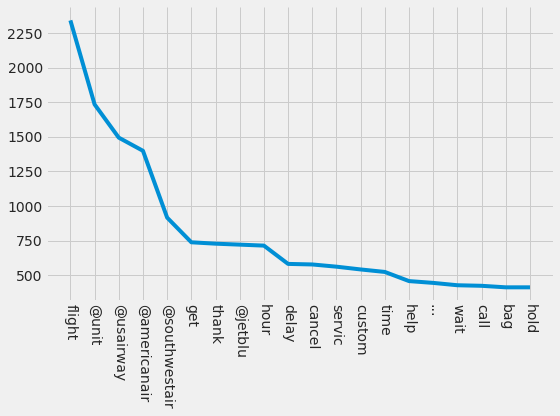

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

y = pd.Series(dict(fdist.most_common()[:20]))
y = y.sort_values(ascending=False)

y.plot()

indexes = np.arange(0, len(y)) # we will place ticks for every word
ax.set_xticks(indexes)
ax.set_xticklabels(y.index, rotation='-90')
ax.set_xlim(-1)

plt.tight_layout()

sns.despine()
plt.show()

This is the expected [distribution](https://ru.wikipedia.org/wiki/Закон_Ципфа)

Zipf's law - an empirical regularity of frequency distribution of natural language words: if all words of a language (or just a sufficiently long text) are ordered by decreasing frequency of their use, the frequency of the n-th word in such a list will be approximately inversely proportional to its ordinal number n (the so-called rank of this word, see the order scale). For example, the second most frequently used word is about twice as rare as the first, the third is three times as rare as the first, and so on.

Now we do something similar for positive and negative tweets separately. We introduce some changes by computing the proportion of tweets in which the word appears and then sorting the words accordingly in descending order. 

This analysis gives us important clues for building a classifier. First, nearly half of the positive tweets contain the "thank" word, suggesting that this will be a powerful feature for classification. Not surprisigly, word such as "great", "love", "best", and "awesome" are among the most frequent in the positive tweets, and do not appear among the most frequent negative tweets. In the same way, "delay", "cancel", and "wait" are among the most frequent for negative tweets and are not among the most frequent among positive tweets.

A third group of words, such as "flight" and "service", are frequent among both positive and negative tweets and may not be very useful for classification. 

In [ ]:
positives=len(train[train['airline_sentiment']=='positive']) # number of positive tweets in the training data

fdist_positive = nltk.FreqDist()
for words in train[train['airline_sentiment']=='positive']['tokens']:
    for word in np.unique(words): # not counting repeated words this time
            fdist_positive[word] += 1

            
common_positive = pd.Series(dict(fdist_positive))/positives # there is probably a better way to do this
common_positive = common_positive.sort_values(ascending=False)
common_positive.head(20).round(3)

thank             0.476
@southwestair     0.256
@jetblu           0.230
@unit             0.201
flight            0.178
@americanair      0.149
great             0.119
@usairway         0.110
servic            0.084
love              0.081
@virginamerica    0.069
custom            0.068
fli               0.068
best              0.066
guy               0.064
help              0.060
good              0.053
get               0.052
much              0.050
awesom            0.049
dtype: float64

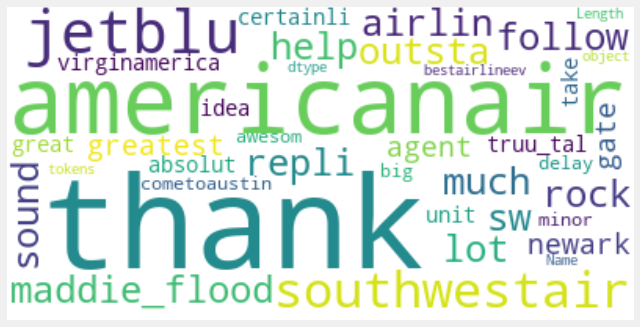

In [ ]:
positive_tweets = train[train['airline_sentiment']=='positive']['tokens']

from wordcloud import WordCloud

fig, ax = plt.subplots(figsize=(10,8))
wordcloud = WordCloud(background_color="white", max_words=200).generate(str(positive_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

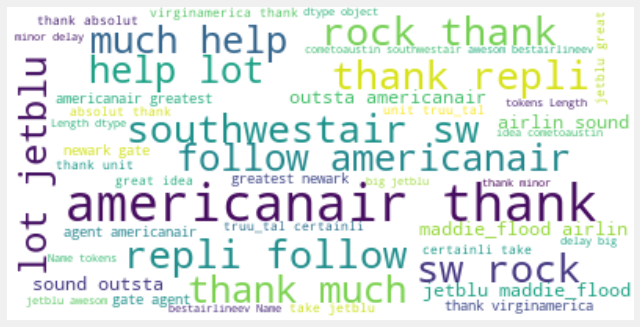

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
wordcloud = WordCloud(background_color="white", max_words=200,collocation_threshold = 2).generate(str(positive_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
negatives=len(train[train['airline_sentiment']=='negative'])

fdist_negative = nltk.FreqDist()
for words in train[train['airline_sentiment']=='negative']['tokens']:
    for word in np.unique(words): 
            fdist_negative[word] += 1

common_negative = pd.Series(dict(fdist_negative))/negatives
common_negative = common_negative.sort_values(ascending=False)
common_negative.head(20).round(3)

flight           0.320
@unit            0.292
@usairway        0.264
@americanair     0.239
hour             0.128
@southwestair    0.125
get              0.124
cancel           0.103
delay            0.102
@jetblu          0.092
servic           0.089
custom           0.088
time             0.086
hold             0.076
wait             0.075
help             0.073
call             0.071
...              0.071
bag              0.067
plane            0.060
dtype: float64

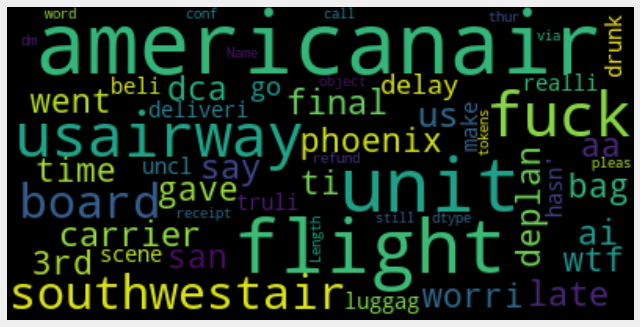

In [ ]:
negative_tweets = train[train['airline_sentiment']=='negative']['tokens']
fig, ax = plt.subplots(figsize=(10,8))
wordcloud = WordCloud(background_color="black", max_words=100).generate(str(negative_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

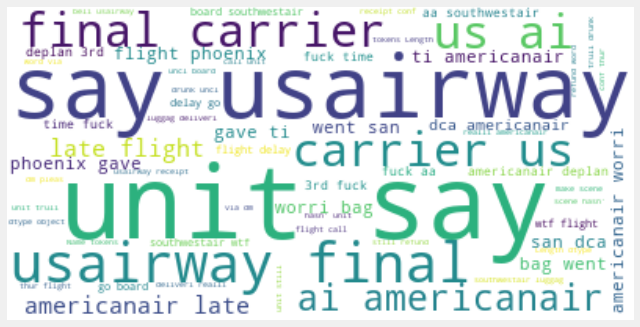

In [ ]:
negative_tweets = train[train['airline_sentiment']=='negative']['tokens']
fig, ax = plt.subplots(figsize=(10,8))
wordcloud = WordCloud(background_color="white", max_words=100,collocation_threshold = 2).generate(str(negative_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In sentiment analysis, it is common to use hierachical classifiers that first classify a document as expressing a neutral or non-neutral sentiment, and then classify the sentiment in the documents that are predicted to be polar.

We simplify our analysis by considering only the positive and the negatives tweets. Furthermore, we only keep the tweets that were classified with full confidence by the contributors.

### Text Processing

Text analysis requires careful processing of the raw text data to convert documents into a format that is amenable to analysis. The four steps that we implement here are:


<ol style="margin-left: 20px">
  <li style="margin-top: 12px;"> Tokenization: separate the text into words for a bag of words represenation.</li>
  <li style="margin-top: 12px;">Removing uninformative punctuation.</li>
  <li style="margin-top: 12px;">Removing stopwords (non-discriminative words such as "the" and "to").</li>
  <li style="margin-top: 12px;">Stemming and lemmatization: converting words to a root form. For example, it may be more useful to consider "democracy", "democracies", "democratic", and "democratization" as the same token.</li>
</ol>

In [ ]:
from nltk.tokenize import TweetTokenizer

tweet=train.loc[2287, 'text'] 
Tokenizer = TweetTokenizer()
tokenized = Tokenizer.tokenize(tweet)


print('Original:')
print(tweet)
print('\nTokenized:')
print(tokenized)

Original:
@united says @USAirways  is the final carrier . Us air doesnt have it. I want my bag!!! Not a claim not an im  sorry. I want my clothes!!

Tokenized:
['@united', 'says', '@USAirways', 'is', 'the', 'final', 'carrier', '.', 'Us', 'air', 'doesnt', 'have', 'it', '.', 'I', 'want', 'my', 'bag', '!', '!', '!', 'Not', 'a', 'claim', 'not', 'an', 'im', 'sorry', '.', 'I', 'want', 'my', 'clothes', '!', '!']


In [ ]:
import string
tokenized_no_punctuation=[word.lower() for word in tokenized if word not in string.punctuation]
print(tokenized_no_punctuation)

['@united', 'says', '@usairways', 'is', 'the', 'final', 'carrier', 'us', 'air', 'doesnt', 'have', 'it', 'i', 'want', 'my', 'bag', 'not', 'a', 'claim', 'not', 'an', 'im', 'sorry', 'i', 'want', 'my', 'clothes']


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
tokenized_no_stopwords=[word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
print(tokenized_no_stopwords)

['@united', 'says', '@usairways', 'final', 'carrier', 'us', 'air', 'doesnt', 'want', 'bag', 'claim', 'im', 'sorry', 'want', 'clothes']


There are different methods for stemming and lemmatization immediately available in the NLTK package. We pick one below.

In [ ]:
from nltk.stem.porter import PorterStemmer
tokens = [PorterStemmer().stem(word) for word in tokenized_no_stopwords]
print(tokens)

['@unit', 'say', '@usairway', 'final', 'carrier', 'us', 'air', 'doesnt', 'want', 'bag', 'claim', 'im', 'sorri', 'want', 'cloth']


We put all these steps below into a function that we can apply to the tweets to create a data column containing the tokens. 

In [ ]:
# this cell may take over a minute to run
from nltk.tokenize import TweetTokenizer
Tokenizer = TweetTokenizer()

def process_text(text):
    tokenized = Tokenizer.tokenize(text)
    tokenized_no_punctuation=[word.lower() for word in tokenized if word not in string.punctuation]
    tokenized_no_stopwords=[word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
    tokens = [PorterStemmer().stem(word) for word in tokenized_no_stopwords if word != '️']
    tokens = [word for word in tokens if word.isalpha()]
    return tokens

train['tokens']=train['text'].apply(process_text) # applies a function separately to each element of a column      

### Bag of words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
train.head(1)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,tokens,positive
2287,569275476642013186,negative,1.0,Lost Luggage,1.0,United,NaN,keykeydoodle,NaN,0,@united says @USAirways is the final carrier ...,NaN,2015-02-21 15:20:24 -0800,Wonderland,Eastern Time (US & Canada),"[@unit, say, @usairway, final, carrier, us, ai...",0


In [ ]:
train['text_clean'] = train['tokens'].apply(lambda x: ' '.join(x))

In [ ]:
train['text_clean'][2287]

'say final carrier us air doesnt want bag claim im sorri want cloth'

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 2),min_df=20,stop_words='english')
count_matrix = vectorizer.fit_transform(train['text_clean'])

In [ ]:
count_matrix

<6227x560 sparse matrix of type '<class 'numpy.int64'>'
	with 46657 stored elements in Compressed Sparse Row format>

In [ ]:
bag_of_word = pd.DataFrame(data = count_matrix.toarray(),columns = vectorizer.get_feature_names_out())
bag_of_word

,aa,abl,absolut,accept,accommod,account,actual,ad,agent,ago,...,worst,worst airlin,worst custom,wow,wrong,wtf,ye,year,yesterday,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6224,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF

In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform. The weight of a word is proportional to how often that word is used in a document and inversely proportional to how often that word is used in all documents in the collection.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

If a tweet contains 100 words and the word "delay" occurs 3 times in it, the word frequency (TF) for the word "delay" in the document will be 0.03 (3/100). Let's calculate IDF as the decimal logarithm of the ratio of the number of all documents to the number of documents containing the word "delay". Thus, if "delay" is contained in 1000 documents out of 6000 documents, the IDF will be: log(6000/1000) = 0.778. To calculate the final word weight, multiply TF by IDF. In this example, the TF-IDF weight for the word "hare" in the selected document will be: 0.03 × 0.778 = 0.02334.

If a word occurs very often, but only in negative reviews, we may underestimate its weight too much. So we can disable the idf parameter if we write use_idf=False.

In [ ]:
tf_idf_vectorizer = TfidfVectorizer(min_df=20,stop_words='english')
tf_idf_matrix = tf_idf_vectorizer.fit_transform(train['text_clean'])

In [ ]:
tf_idf_features = pd.DataFrame(data = tf_idf_matrix.toarray(),columns = tf_idf_vectorizer.get_feature_names_out())
tf_idf_features

,aa,abl,absolut,accept,accommod,account,actual,ad,agent,ago,...,work,wors,worst,wow,wrong,wtf,ye,year,yesterday,zero
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
3,0.364989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.41335,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6222,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
6223,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
6224,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.37999,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
6225,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0


In [ ]:
tf_idf_features.iloc[0,:][tf_idf_features.iloc[0,:]>0]

air      0.327286
bag      0.219770
claim    0.322453
final    0.313858
im       0.379454
say      0.273617
sorri    0.350593
want     0.548029
Name: 0, dtype: float64

In [ ]:
tf_idf_features.iloc[1,:][tf_idf_features.iloc[1,:]>0]

arriv      0.270196
away       0.333714
bag        0.198090
chicago    0.671339
drive      0.330012
flight     0.114871
gave       0.310822
hr         0.240562
late       0.221608
Name: 1, dtype: float64

In [ ]:
tf_vectorizer = TfidfVectorizer(min_df=20,stop_words='english',use_idf=False)
tf_matrix = tf_vectorizer.fit_transform(train['text_clean'])
tf_features = pd.DataFrame(data = tf_matrix.toarray(),columns = tf_vectorizer.get_feature_names_out())
tf_features.iloc[1,:][tf_features.iloc[1,:]>0]

arriv      0.288675
away       0.288675
bag        0.288675
chicago    0.577350
drive      0.288675
flight     0.288675
gave       0.288675
hr         0.288675
late       0.288675
Name: 1, dtype: float64

### Word embeddings

In 2013 T.Mikolov introduced the word2vec algorithm, which translates each word into some vector space. In this vector space, words with similar meanings are close to each other. Moreover, sometimes we can use addition and subtraction operations (As shown in the picture below)

If you want to learn more about word embeddings, I recommend this [online-book](https://lena-voita.github.io/nlp_course/word_embeddings.html)

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/w2v.png?raw=true:, width=800" alt="My Image" width=800>

You can use library [gensim](https://radimrehurek.com/gensim/models/word2vec.html) if you have enough data (500k-1 000k words). Unfortunately, there are not enough words in our data.

[Word2Vec picture](https://lilianweng.github.io/posts/2017-10-15-word-embedding/)

There is a more modern model - fasttext, which can be [downloaded](https://fasttext.cc/docs/en/english-vectors.html) for different languages and used without prior training. In my experience I can say that it is trained very well.

It takes a long time to upload such a model to google colab, so let's consider another way. Let's use the hugging face library. In fact, it's not just a library, it's a whole service. A large number of deep learning models for text manipulation can be found on this platform, although other neural networks have been appearing there recently.

In [1]:
!pip install transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.6 MB/s 
     |████████████████████████████████| 1.3 MB 37.5 MB/s 
     |████████████████████████████████| 182 kB 49.9 MB/s 
     |████████████████████████████████| 7.6 MB 31.0 MB/s 


We will use the vector representations that form the [BART](https://paperswithcode.com/method/bart) neural network. The point is that the neural networks on each layer highlight some small patterns. On the first layer we have many neurons, each of which defines one small feature. Then each subsequent layer aggregates features from the previous layer. So we take the weights from the last layer of the neural network.

In [2]:
from transformers import BartTokenizer, BartModel

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartModel.from_pretrained('facebook/bart-base')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
train['text_clean'][[2287,14384]]

2287     say final carrier us air doesnt want bag claim...
14384    late flight phoenix gave tick away arriv chica...
Name: text_clean, dtype: object

In [ ]:
inputs = tokenizer(train['text_clean'][2287], return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

In [ ]:
last_hidden_states

tensor([[[ 2.3086,  2.3814,  1.4925,  ...,  1.8878,  0.1212, -0.6143],
         [-0.1051, -0.1873, -1.2365,  ...,  0.6798,  1.2441,  0.7595],
         [-0.4312,  1.1535,  0.1019,  ...,  0.4689,  1.1130, -0.0791],
         ...,
         [-0.4168, -0.6886,  0.3898,  ...,  0.1923,  3.2965, -0.0953],
         [-0.3309,  0.3878,  0.0588,  ...,  1.8909,  1.1949,  0.4873],
         [-0.5839, -0.8807, -0.0482,  ...,  1.8842, -1.0776,  0.4414]]],
       grad_fn=<NativeLayerNormBackward0>)

In [4]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import torch

Now we have to average the vectors of words and get the vector of the whole sentence.

In [ ]:
emb = torch.mean(last_hidden_states, 1).detach().cpu().resolve_conj().resolve_neg().numpy()

In [ ]:
emb.shape

(1, 768)

In [6]:
def sentece_to_vec(x):
  inputs = tokenizer(x, return_tensors="pt")
  outputs = model(**inputs)
  last_hidden_states = outputs.last_hidden_state
  return torch.mean(last_hidden_states, 1).detach().cpu().resolve_conj().resolve_neg().numpy()

In [ ]:
embeddings_list = []
for i in train['text_clean']:
  embeddings_list.append(sentece_to_vec(i))

In [ ]:
embedding_matrix = np.vstack(embeddings_list)

In [ ]:
embedding_matrix.shape

(6227, 768)

In [ ]:
train.reset_index(inplace=True)

In [ ]:
first_100 = list(set(' '.join(train['text_clean'][0:500]).split()))

In [ ]:
embeddings_list = []
for i in first_100:
  embeddings_list.append(sentece_to_vec(i))

embedding_matrix_100 = np.vstack(embeddings_list)

Thus, we got a matrix with new features that describe our tweets. Often these features are used in conjunction with numeric and categorical attributes.

Let's create a function to determine the closest words to the given one. This will help us evaluate the adequacy of the resulting model.

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels

In [ ]:
distance100 = 1-pairwise_distances(embedding_matrix_100, metric="cosine")

In [ ]:
embedding_matrix_100.shape

(910, 768)

In [ ]:
distance100.shape

(910, 910)

In [ ]:
def find_closest(position):
  print(f'Word: {first_100[np.argsort(distance100[position])[-1]]}')
  print(f'Top 1: {first_100[np.argsort(distance100[position])[-2]]}')
  print(f'Top 2: {first_100[np.argsort(distance100[position])[-3]]}')
  print(f'Top 3: {first_100[np.argsort(distance100[position])[-4]]}')
  print(f'Top 4: {first_100[np.argsort(distance100[position])[-5]]}')
  print(f'Top 5: {first_100[np.argsort(distance100[position])[-6]]}')

In [ ]:
find_closest(878)

Word: idiot
Top 1: asid
Top 2: consid
Top 3: kid
Top 4: kid
Top 5: danc


In [ ]:
find_closest(500)

Word: drunk
Top 1: drink
Top 2: night
Top 3: night
Top 4: night
Top 5: kid


In [ ]:
find_closest(600)

Word: lack
Top 1: lax
Top 2: ladi
Top 3: loyal
Top 4: phl
Top 5: littl


Let's see how it works on other data.

In [38]:
test_words = ['pizza','cheese','mashrooms','tomatoes','basil','ham','pineapple','MIT','Oxford','Stanford','Chelsea','Bayern','Everton','Barcelona','Boston','Moscow','London']

In [39]:
embeddings_list = []
for i in test_words:

  inputs = tokenizer(i, return_tensors="pt")
  outputs = model(**inputs)
  last_hidden_states = outputs.last_hidden_state
  embeddings_list.append(sentece_to_vec(i))

embedding_matrix = np.vstack(embeddings_list)

In [11]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.6 MB/s 
     |████████████████████████████████| 1.1 MB 41.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=c284d01b760deb150e013a249e5477b6ad0703426d9f7eefb11d60f3dfd1321a
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=72c13facfb6190f0af95c76a7b694ead0777e9157dad7fe1ad0dadd1ba327bdc
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [12]:
import umap

In [40]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(embedding_matrix)
embedding.shape

(17, 2)

In [14]:
import plotly.express as px

In [41]:
df = pd.DataFrame(embedding,columns=['ft1','ft2'])
df['word'] = test_words
df['dummy_column_for_size'] = 1.

In [42]:
fig = px.scatter(df, x=df.ft1, y=df.ft2, color=df.word, size = df.dummy_column_for_size,text=df.word)
fig.update_layout(
    width=1500,
    height=1000
)
fig.update_traces(textposition="bottom center",textfont_size=18)
fig.show()

We can see that the food is grouped in a separate cluster. Does this help answer the question: does pineapple pizza have the right to exist? Universities and cities are also located as expected. Barcelona found itself between football clubs and cities. But don't forget that by reducing the dimensionality with UMAP we lose quite a lot of information. The number of features decreased from 768 to 2.

Another option is to feed the result of some model as a feature. For example, a model that determines the tone of the text.

In [47]:
from transformers import pipeline

In [48]:
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [49]:
classifier("I don't trust the company American Airlains")

[{'label': 'NEGATIVE', 'score': 0.9996386766433716}]

In [50]:
classifier("@united stuck here in IAH waiting on flight 253 to Honolulu for 7 hours due to maintenance issues. Could we have gotten a new plane!?!? Fail")

[{'label': 'NEGATIVE', 'score': 0.9997058510780334}]

In [51]:
classifier("JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!")

[{'label': 'POSITIVE', 'score': 0.9995205402374268}]

Or, for example, you can extract entities from text

In [53]:
ner = pipeline('ner')

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/998 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [54]:
ner("I don't trust the company American Airlains")

[{'entity': 'I-ORG',
  'score': 0.99631846,
  'index': 8,
  'word': 'American',
  'start': 26,
  'end': 34},
 {'entity': 'I-ORG',
  'score': 0.99516606,
  'index': 9,
  'word': 'Air',
  'start': 35,
  'end': 38},
 {'entity': 'I-ORG',
  'score': 0.9287972,
  'index': 10,
  'word': '##lain',
  'start': 38,
  'end': 42},
 {'entity': 'I-ORG',
  'score': 0.7009791,
  'index': 11,
  'word': '##s',
  'start': 42,
  'end': 43}]

In [55]:
ner("JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!")

[{'entity': 'I-ORG',
  'score': 0.9992101,
  'index': 1,
  'word': 'Jet',
  'start': 0,
  'end': 3},
 {'entity': 'I-ORG',
  'score': 0.99707925,
  'index': 2,
  'word': '##B',
  'start': 3,
  'end': 4},
 {'entity': 'I-ORG',
  'score': 0.9950081,
  'index': 3,
  'word': '##lue',
  'start': 4,
  'end': 7},
 {'entity': 'I-LOC',
  'score': 0.9988589,
  'index': 9,
  'word': 'Orlando',
  'start': 30,
  'end': 37},
 {'entity': 'I-LOC',
  'score': 0.9965249,
  'index': 11,
  'word': 'Hartford',
  'start': 43,
  'end': 51}]

Or you can get a shorter sentence with the main idea of the text and then work with it.

In [60]:
summarizator = pipeline('summarization',model='google/pegasus-xsum')

Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [61]:
summarizator('JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!', min_length=1, max_length=6)

[{'summary_text': 'Great flight!'}]

If you have some business problem that you can't solve with the methods we've learned but can reformulate into a machine learning problem, you can probably find the most appropriate way to solve it [here](https://paperswithcode.com/sota)